In [67]:
from wfield import *
import os 
import h5py
import pandas as pd
from scipy.io import loadmat
from scipy.signal import savgol_filter

In [68]:
directory = "C:/Behavior/Animals/"
animal = "FV-4/"
maze = "SD/"
session = "12-Jul-2022/"
file = "{}/"
sync = "sync"
path_sync = os.path.join(directory, animal, maze, session, sync)
os.chdir(path_sync)
print(path_sync)

C:/Behavior/Animals/FV-4/SD/12-Jul-2022/sync


In [69]:
df = pd.read_csv('All_data.csv')
df

,Unnamed: 0,trial,img session,start frame,end frame,correct
0,0,1,1,-56,236,1
1,1,2,1,335,485,0
2,2,3,1,806,1072,1
3,3,4,1,1172,1365,1
4,4,5,1,1460,1649,1
...,...,...,...,...,...,...
225,25,226,8,7030,7200,1
226,26,227,8,7294,7488,0
227,27,228,8,7809,7967,1
228,28,229,8,8061,8243,1


In [70]:
def get_sesh_actvity(img_session):
    file = "{}"
    path_file = os.path.join(directory, animal, maze, session, file.format(img_session))
    os.chdir(path_file)
    print(path_file)
    U = np.load('U.npy')
    SVT = np.load('SVT.npy')
    stack = SVDStack(U,SVT)
    lmarks = load_allen_landmarks('dorsal_cortex_landmarks.json')

    ccf_regions_reference,proj,brain_outline = allen_load_reference('dorsal_cortex')
    # the reference is in allen CCF space and needs to be converted
    # this converts to warped image space (accounting for the transformation)
    ccf_regions = allen_transform_regions(None,ccf_regions_reference,
                                          resolution = lmarks['resolution'],
                                            bregma_offset = lmarks['bregma_offset'])
    atlas, areanames, brain_mask = atlas_from_landmarks_file('dorsal_cortex_landmarks.json') # this loads the atlas in transformed coords

    # this does the transform (warps the original images)
    stack.set_warped(1, M = lmarks['transform']) # this warps the spatial components in the stack

    # this converts the reference to image space (unwarped)
    atlas_im, areanames, brain_mask = atlas_from_landmarks_file('dorsal_cortex_landmarks.json',do_transform = True) # this loads the untransformed atlas
    ccf_regions_im = allen_transform_regions(lmarks['transform'],ccf_regions_reference,
                                            resolution = lmarks['resolution'],
                                            bregma_offset = lmarks['bregma_offset'])
    #load z-scored activity matrices
    activityR_zscored = savgol_filter(np.load('activityR_zscored.npy'),6, 1)
    activityL_zscored = savgol_filter(np.load('activityL_zscored.npy'),6, 1)

    df_sesh = df[df['img session'] == img_session]
    x = df_sesh.index.tolist()

    sesh_activity = []
    for i in x:
        trial = i
        start = df_sesh['start frame'][trial] 
        stop =  df_sesh['end frame'][trial]
        trial_activity = []
        if start < 0:
            area = list(range(33))
            for x in area:
                trial_activity.append(0)
        elif start > 0:
            area = list(range(33))
            for x in area:
                trial_activity.append(activityR_zscored[x][start:stop])
        sesh_activity.append(trial_activity)
    sesh_activity = np.array(sesh_activity, dtype=object)
    return sesh_activity
    #np.save('sesh_activity.npy', sesh_activity, allow_pickle=True)

In [71]:
group_act = np.concatenate([get_sesh_actvity(img_session = 1),
                           get_sesh_actvity(img_session = 2),
                           get_sesh_actvity(img_session = 3),
                           get_sesh_actvity(img_session = 4),
                           get_sesh_actvity(img_session = 5),
                           get_sesh_actvity(img_session = 6),
                           get_sesh_actvity(img_session = 7),
                           get_sesh_actvity(img_session = 8)])
os.chdir(path_sync)
np.save('group_act.npy', group_act)

C:/Behavior/Animals/FV-4/SD/12-Jul-2022/1
C:/Behavior/Animals/FV-4/SD/12-Jul-2022/2
C:/Behavior/Animals/FV-4/SD/12-Jul-2022/3
C:/Behavior/Animals/FV-4/SD/12-Jul-2022/4
C:/Behavior/Animals/FV-4/SD/12-Jul-2022/5
C:/Behavior/Animals/FV-4/SD/12-Jul-2022/6
C:/Behavior/Animals/FV-4/SD/12-Jul-2022/7
C:/Behavior/Animals/FV-4/SD/12-Jul-2022/8


In [72]:
group_act_load = np.load('group_act.npy', allow_pickle = True)

In [74]:
lmarks = load_allen_landmarks('dorsal_cortex_landmarks.json')
ccf_regions_reference,proj,brain_outline = allen_load_reference('dorsal_cortex')
# the reference is in allen CCF space and needs to be converted
# this converts to warped image space (accounting for the transformation)
ccf_regions = allen_transform_regions(None,ccf_regions_reference,
                                      resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])
atlas, areanames, brain_mask = atlas_from_landmarks_file('dorsal_cortex_landmarks.json') # this loads the atlas in transformed coords

# this converts the reference to image space (unwarped)
atlas_im, areanames, brain_mask = atlas_from_landmarks_file('dorsal_cortex_landmarks.json',do_transform = True) # this loads the untransformed atlas
ccf_regions_im = allen_transform_regions(lmarks['transform'],ccf_regions_reference,
                                        resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])

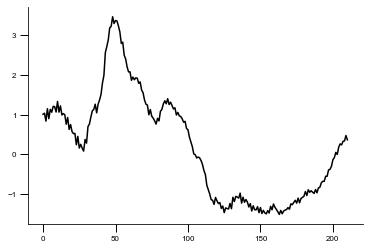

In [75]:
trial = 7
ROI = 32
trial_act = group_act_load[trial][ROI]
plt.plot(trial_act)

In [76]:
len(trial_act)

211

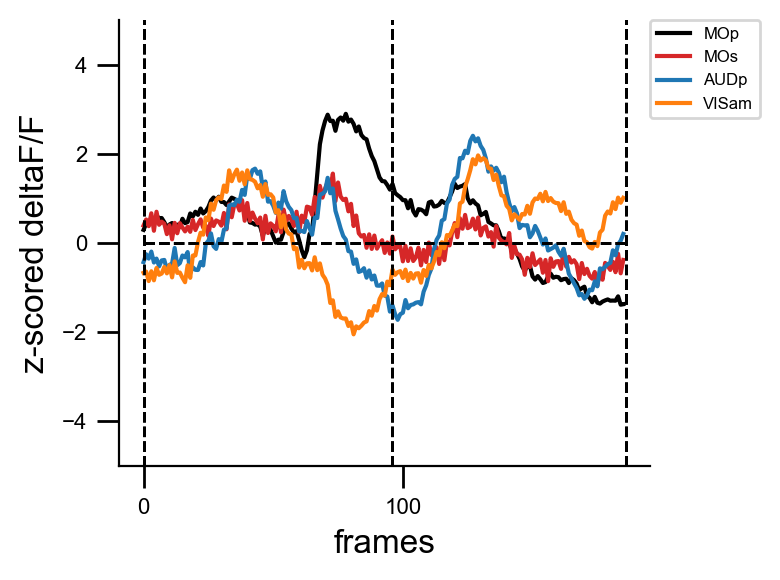

In [77]:
trial = 100
#area = [2,3,8,10,20,32]
area = [2,3,20,31]

fig, axs = plt.subplots(1, 1, figsize = (4,3))
fig.set_dpi(200.0)
for i in area:
    trial_act = group_act_load[trial][i]
    axs.plot(trial_act, label = ccf_regions_im['acronym'][i])
    axs.hlines(y=0, xmin=0, xmax=len(trial_act), colors='black', linestyles='--', lw=1)
    axs.vlines(x=0, ymin=-5, ymax=6, colors='black', linestyles='--', lw=1)
    if df['correct'][trial] == 1:
        axs.vlines(x=len(trial_act)-90, ymin=-5, ymax=6, colors='black', linestyles='--', lw=1)
    elif df['correct'][trial] == 1:
        axs.vlines(x=len(trial_act)-150, ymin=-5, ymax=6, colors='black', linestyles='--', lw=1)
    axs.vlines(x=len(trial_act), ymin=-5, ymax=6, colors='black', linestyles='--', lw=1)
    axs.legend()
    axs.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0,  prop={'size': 6})
    axs.locator_params(axis='x', nbins=4)
    axs.set_xlabel('frames')
    axs.set_ylabel('z-scored deltaF/F')
    axs.set_ylim([-5,5]);

fig.tight_layout()